# Predykcja bez użycia kolumny `RESIGN_DATE`

### Importy bibliotek

In [9]:
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
from kneed import KneeLocator
from sklearn.cluster import KMeans

### Zczytanie danych z plików csv

* Pliki znajdują sie w folderze data i mają nazwy
    * PPK_Uczestnicy.csv
    * PPK_Pracodawcy.csv
* Po zczytaniu operacja merge złaczamy dane tak, że informacja o pracodawcy jest dostepna z poziomu pracownika

In [2]:
# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv', sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)


### Zmiana kolumnn i początkowe wyczyszczenie DataFrame'u 

* Drop'owanie niepotrzebnych kolumn które nie będą przydatne

* Kolumna Age ta niestety została obarczona przenikami przez co była błędnie reprezentowana jako typ String, przerabiamy ją na typ int

* Przerobienie narodowości na mniejszą ilość podgrup, decyzja o przejsciu na wszystkie grupy z iloscia osob mniejsza niz 5000 naleza do jednej narodowsci

* Zmiana kolumn kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę

* Znajdowanie `DURATION`, które jest różnicą między data podpisania (`SIGN_DATE`) a dzisiejsza data, typ to int - liczba dni

In [3]:
# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID',
                 'EMPL_ID',  
                 'LOGICAL_FACTOR_1',
                 'LOGICAL_FACTOR_2',
                 'ID',
                 'PKD_CODE',
                 'NUMERICAL_VALUE'], inplace = True)

# Te kolumny niby jakoś możnaby wykorzystać, ale wątpliwe, że coś by z tego wynikło
df.drop(columns =["CREATED_AT", 
                  "UOZ_START_DATE", 
                  "UOP_SIGN_DATE", 
                  'REGION_CODE',
                  'WORK_START', 
                  'WORK_STOP'], inplace = True)

# no i to trzeba wyrzucic
df.drop(columns = ["RESIGN_DATE"], inplace = True)

In [4]:
# Age to int
def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [5]:
# Grouping other nationalities into one category '0'

unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0       

In [6]:
# zamiana danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE', 'PPK_BANK'], 
                         prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE', 'PPK_BANK'])

In [7]:
# duration - czas od zapisania się do teraz
def find_period(start):
    stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days

df['DURATION'] = df['SIGN_DATE'].apply(find_period) 
df.drop(columns = ['SIGN_DATE'], inplace = True)

### Klasteryzacja wieku

Z korelacją `IS_SUSPENDED`, nie sam podzial wieku

Zaczynamy od sprawdzenia jaka ilosc klastrów najlepiej się sprawdzi

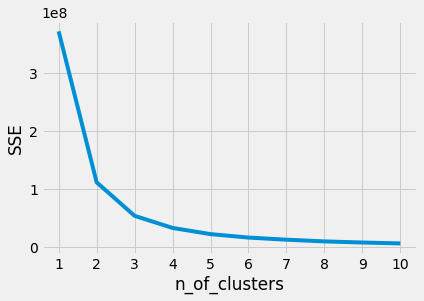

In [10]:
dataset = df[['IS_SUSPENDED', 'AGE']]

scaled_dataset = dataset.values

kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_dataset)
    sse.append(kmeans.inertia_)

plt.style.use('fivethirtyeight')
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("n_of_clusters")
plt.ylabel("SSE")
plt.show()


kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
n_of_clusters = kl.elbow

kmeans = KMeans(
    init='random',
    n_clusters = n_of_clusters,
    n_init=50,
    max_iter=500,
    random_state=42
    )

kmeans.fit(scaled_dataset)

df['AGE_CL'] = kmeans.predict(df[["IS_SUSPENDED", "AGE"]])

df.drop(columns=["AGE"], inplace=True)

### Jak ostatecznie wygląda df (DataFrame)

In [11]:
df

,IS_SUSPENDED,HAS_AE,HAS_AW,HAS_IP,SEX_K,SEX_M,SEX_N,COMPANY_SIZE_A,COMPANY_SIZE_B,COMPANY_SIZE_C,...,PPK_BANK_13,PPK_BANK_14,PPK_BANK_15,PPK_BANK_16,PPK_BANK_17,PPK_BANK_18,PPK_BANK_19,PPK_BANK_20,DURATION,AGE_CL
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,555,2
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,476,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,476,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,476,2
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,476,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793206,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,404,2
1793207,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,404,0
1793208,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,404,1
1793209,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,404,0


### Podział na dane treningowe i testowe

In [12]:
# test/train split
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], 
                                                    df["IS_SUSPENDED"], 
                                                    stratify=df["IS_SUSPENDED"], 
                                                    test_size=0.10, 
                                                    random_state=56)

### Gradient Boosting

Klasy są niezbalansowane, więc trzeba przeskalować wagi pozytywnej klasy

In [13]:
pos = df["IS_SUSPENDED"].sum()/len(df)
scalar = (1-pos)/pos

In [14]:
XGB = XGBClassifier(max_depth=5, 
                  learning_rate=0.1, 
                  objective= 'binary:logistic',
                  n_jobs=-1,
                  use_label_encoder = False,
                  scale_pos_weight = scalar,
                  verbosity=0)
                                
    
xgb_model = XGB.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [15]:
y_pred = xgb_model.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89    148055
           1       0.50      0.72      0.59     31267

    accuracy                           0.82    179322
   macro avg       0.72      0.78      0.74    179322
weighted avg       0.86      0.82      0.84    179322



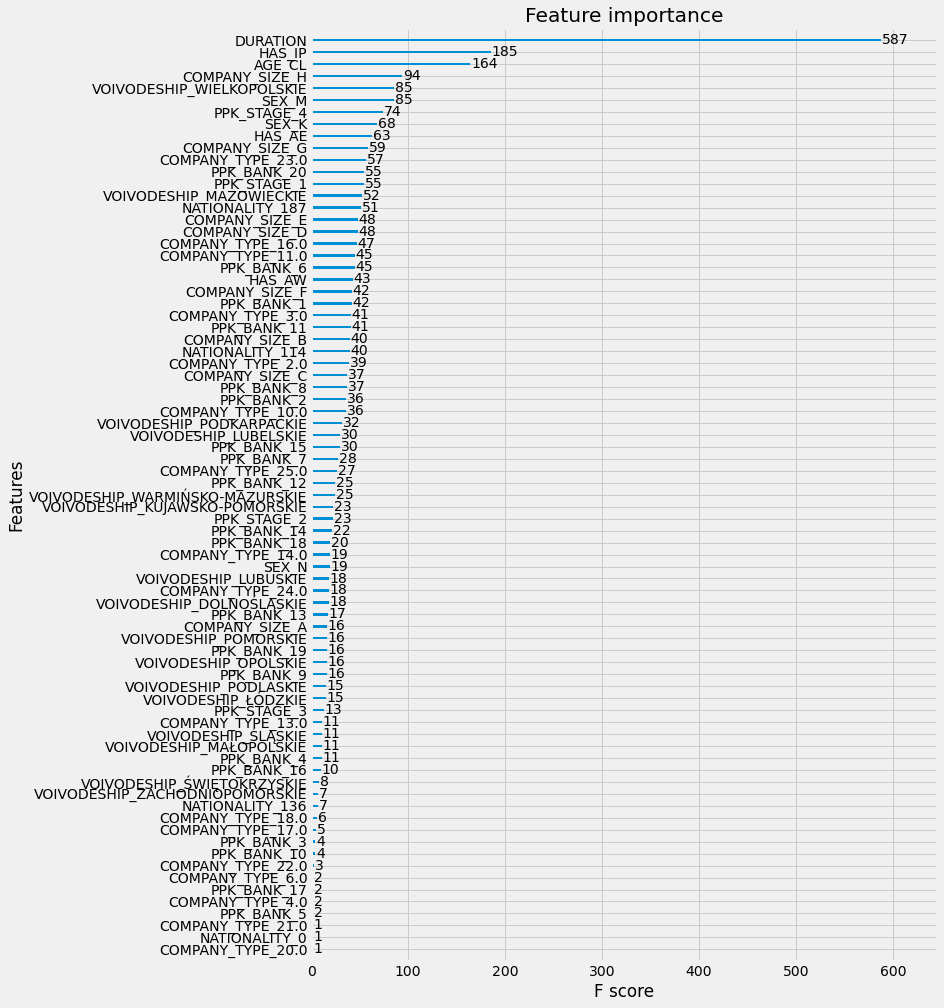

In [23]:
fig, ax = plt.subplots(figsize=(10,16))
plot_importance(xgb_model, ax=ax)

# plt.savefig("without_resign_date.pdf")


### Testowe dane, przerobienie ich tak jak na poczatku danych treningowych

In [18]:
# test 

df_test = pd.read_csv("data/PPK_Uczestnicy_TEST.csv", sep=';')
# Mergowanie dwóch csv
df_test = pd.merge(
    df_test,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)

# Dropowanie niepotrzebnych kolumn
df_test.drop(columns=['EMPL_ID',  
                 'LOGICAL_FACTOR_1',
                 'LOGICAL_FACTOR_2',
                 'ID',
                 'PKD_CODE',
                 'PPK_BANK',
                 'NUMERICAL_VALUE'], inplace = True)

# Te kolumny niby jakoś możnaby wykorzystać, ale wątpliwe, że coś by z tego wynikło
df_test.drop(columns =["CREATED_AT", 
                  "UOZ_START_DATE", 
                  "UOP_SIGN_DATE", 
                  'REGION_CODE',
                  'WORK_START', 
                  'WORK_STOP'], inplace = True)

# no i to trzeba wyrzucic heh
df_test.drop(columns = ["RESIGN_DATE"], inplace = True)

# Age to int

def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df_test["AGE"] = df_test["AGE"].apply(to_int)

# Grouping other nationalities into one category '0'

unique_nat = df_test['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df_test['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df_test.loc[df_test.NATIONALITY == val, 'NATIONALITY'] = 0   
        
# zamiana danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
df_test = pd.get_dummies(df_test, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'], 
                         prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'])

# duration - czas od zapisania się do teraz
def find_period(start):
    stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days

df_test['DURATION'] = df_test['SIGN_DATE'].apply(find_period) 
df_test.drop(columns = ['SIGN_DATE'], inplace = True)

In [19]:
df_test.head()

,MEMBER_ID,AGE,HAS_AE,HAS_AW,HAS_IP,SEX_K,SEX_M,SEX_N,COMPANY_SIZE_A,COMPANY_SIZE_B,...,VOIVODESHIP_ŚWIĘTOKRZYSKIE,NATIONALITY_0,NATIONALITY_114,NATIONALITY_136,NATIONALITY_187,PPK_STAGE_1,PPK_STAGE_2,PPK_STAGE_3,PPK_STAGE_4,DURATION
0,2754560,56,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,555
1,2106297,77,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,476
2,2106308,87,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,476
3,2106301,69,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,476
4,2152759,70,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,456


### Predykcja według modelu

In [20]:
y_pred = xgb_model.predict( df_test[df_test.columns[1:]])

ValueError: Feature shape mismatch, expected: 83, got 964775

In [ ]:
df_pred = pd.DataFrame(data = {"MEMBER_ID": df_test['MEMBER_ID'],"IS_SUSPENDED": y_pred})

In [ ]:
df_pred.shape

### Zapis danych do pliku wyjściowego

In [ ]:
df_pred.to_csv('Falujace_Garnki_submission.csv', index=False, sep=';')